In [1]:
import numpy as np
import pandas as pd
import pickle
import os
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#path = "../../../Google Drive/Data_science/NYU/Machine Learning/ML Project (Collisions)/" #Joe
path = "../../../../Google Drive/ML Project (Collisions)/" # Joyce
# path = "" # Lucas

In [3]:
df = pd.read_csv(path + "NYPD_Motor_Vehicle_Collisions.csv", parse_dates=[['DATE', 'TIME']], infer_datetime_format=True)

In [4]:
df['DATE_TIME'] = pd.to_numeric(df['DATE_TIME'])
df = df.sort_values('DATE_TIME', axis=0, ascending=True)

Loop through the directory

In [5]:
datasets = {}

for file in os.listdir(path+"data_for_joining/"):
    if file.endswith(".pkl"):
        with open(os.path.join(path+"data_for_joining/", file), 'rb') as pkl_file:
            datasets[file.replace(".pkl", "")] = pickle.load(pkl_file, encoding='latin1')

In [6]:
for key, value in datasets.items() :
    if "traffic" in key:
        datasets[key].name = datasets[key].name + '_' + key.split('_')[-1]
    df = df.join(datasets[key], on='UNIQUE KEY', how='left', rsuffix="_"+key)
    print ("%s finished!" % (key))

injury_avgs finished!
traffic_joined_0.06 finished!
traffic_joined_0.03 finished!
traffic_joined_0.3 finished!
Bank_Holidays finished!
lights finished!
subway_joined finished!
311_joined finished!
daylight_joined finished!
traffic_joined_0.1 finished!
self finished!
weather_joined_utm finished!


In [7]:
df.set_index('UNIQUE KEY', inplace=True)

Replace values with inferred lat long values

In [8]:
inferred_datasets = {}

for file in os.listdir(path+"inferred_lat_long_data/"):
    if file.endswith(".pkl"):
        with open(os.path.join(path+"inferred_lat_long_data/", file), 'rb') as pkl_file:
            inferred_datasets[file.replace(".pkl", "")] = pickle.load(pkl_file, encoding='latin1')

In [9]:
for key, value in inferred_datasets.items():
    try:
        replace_columns = inferred_datasets[key].columns.values
    except:
        replace_columns = inferred_datasets[key].name
        
    df.loc[inferred_datasets[key].index, replace_columns] = inferred_datasets[key]
    print ("%s finished!" % (key))

traffic_joined_0.06LATLONGCLEANED finished!
311_joined finished!
traffic_joined_0.3LATLONGCLEANED finished!
traffic_joined_0.03LATLONGCLEANED finished!
traffic_joined_0.1LATLONGCLEANED finished!
subway_joined finished!
weather_joined_utm finished!


In [10]:
renamed_columns = [x.lower().replace(' ', '_') for x in df.columns.values]
    
df.columns = renamed_columns

In [11]:
df.ix[df.longitude[df.longitude < -100].index,'longitude'] = np.nan

(0, 10000)

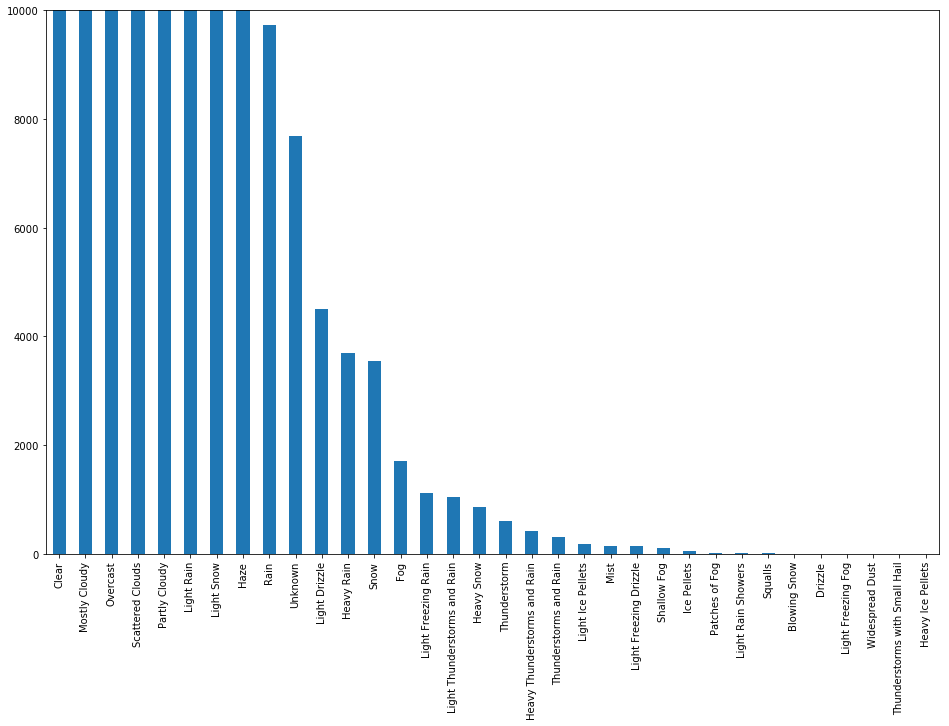

In [12]:
plt.figure(figsize=(16,10))
df['conditions'].value_counts().plot(kind='bar')
plt.ylim([0, 10000])

In [13]:
remap_weather = {'Heavy Snow': 'Snow',
                'Light Freezing Rain': 'Light Rain',
                'Heavy Thunderstorms and Rain': 'Thunderstorms and Rain',
                'Light Thunderstorms and Rain': 'Thunderstorms and Rain',
                'Light Ice Pellets': 'Ice Pellets',
                'Heavy Ice Pellets': 'Ice Pellets',
                'Thunderstorms with Small Hail': 'Thunderstorms and Rain',
                'Shallow Fog': 'Fog',
                'Light Freezing Fog': 'Fog',
                'Mist': 'Fog',
                'Blowing Snow': 'Snow',
                'Drizzle': 'Light Rain',
                'Widespread Dust': 'Haze',
                'Squalls': np.nan,
                'Unknown': np.nan,
                'Light Drizzle': 'Light Rain',
                'Light Freezing Drizzle': 'Light Rain',
                'Patches of Fog': 'Fog',
                'Light Rain Showers': 'Light Rain',
                }

df['conditions'] = df['conditions'].replace(remap_weather)

(0, 10000)

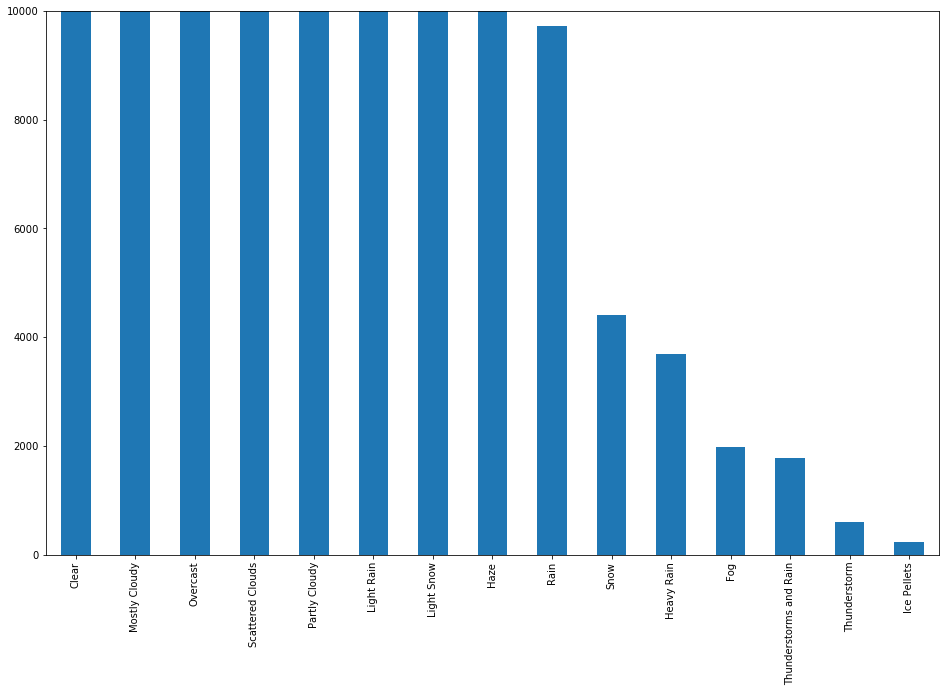

In [14]:
plt.figure(figsize=(16,10))
df['conditions'].value_counts().plot(kind='bar')
plt.ylim([0, 10000])

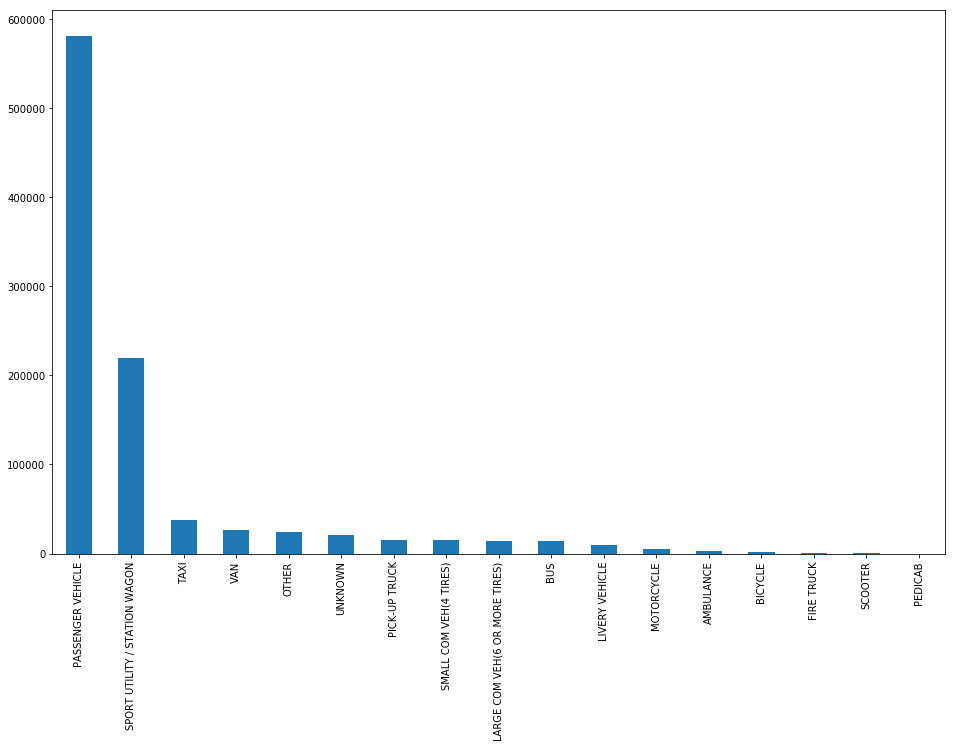

In [15]:
plt.figure(figsize=(16,10))
df['vehicle_type_code_1'].value_counts().plot(kind='bar')

In [16]:
remap_vehicle = {'TAXI': 'SMALL COM VEH(4 TIRES)',
                'BUS': 'LARGE VEHICLE',
                'SCOOTER': 'MOTORCYCLE',
                'LIVERY VEHICLE': 'SMALL COM VEH(4 TIRES)',
                'VAN': 'MEDIUM VEHICLE',
                'PEDICAB': 'BICYCLE',
                'PICK-UP TRUCK': 'MEDIUM VEHICLE',
                'SPORT UTILITY / STATION WAGON': 'MEDIUM VEHICLE',
                'LARGE COM VEH(6 OR MORE TIRES)': 'LARGE VEHICLE',
                'FIRE TRUCK': 'LARGE VEHICLE',
                }

In [17]:
for column in ['vehicle_type_code_1', 'vehicle_type_code_2',
       'vehicle_type_code_3', 'vehicle_type_code_4', 'vehicle_type_code_5']:
    df[column] = df[column].replace(remap_vehicle)

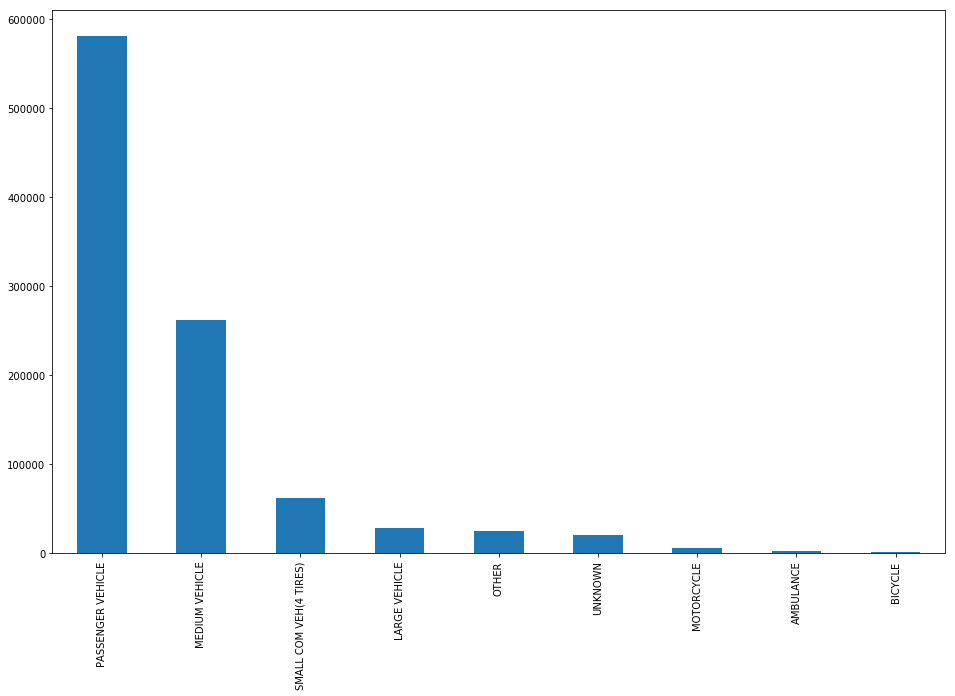

In [18]:
plt.figure(figsize=(16,10))
df['vehicle_type_code_1'].value_counts().plot(kind='bar')

In [20]:
floats = ['latitude', 'longitude','temperature', 'heat_index', 'dew_point', 'humidity', 'pressure',\
          'visibility', 'wind_speed', 'gust_speed', 'precip', 'zip_code']

In [21]:
for column in floats:
    df[column] = pd.to_numeric(df[column], errors='coerce')

In [22]:
with open(path+"data_for_training/v2/predrop_collisions.pkl", 'wb') as outfile:
    pickle.dump(df, outfile)

In [23]:
drop_columns = ['location', 'on_street_name', 'cross_street_name',
       'off_street_name', 'number_of_persons_injured',
       'number_of_persons_killed', 'number_of_pedestrians_injured',
       'number_of_pedestrians_killed', 'number_of_cyclist_injured',
       'number_of_cyclist_killed', 'number_of_motorist_injured',
       'number_of_motorist_killed', 'contributing_factor_vehicle_1',
       'contributing_factor_vehicle_2', 'contributing_factor_vehicle_3',
       'contributing_factor_vehicle_4', 'contributing_factor_vehicle_5',
        'vehicle_type_code_1', 'vehicle_type_code_2', 'vehicle_type_code_3', 
        'vehicle_type_code_4', 'vehicle_type_code_5']

In [24]:
df = df.drop(drop_columns, axis=1)

In [25]:
def fill_nas(df):
    
    for column in df:
        if np.sum(df[column].isnull()) > 0:
            df[column+'_nan'] = df[column].isnull()

            if column == 'zip_code':
                df[column].fillna(df[column].mode()[0], inplace=True)
            elif column in df._get_numeric_data().columns.values:
                df[column].fillna(df[column].mean(), inplace=True)
                
    return df
            
df = fill_nas(df)

In [26]:
np.sum((df.zip_code_nan) & (df.latitude_nan != 1))

90039

In [27]:
onehotdf = pd.get_dummies(df, columns=['borough', 'wind_dir', 'conditions'])

In [28]:
renamed_columns = [x.lower().replace(' ', '_') for x in onehotdf.columns.values]
    
onehotdf.columns = renamed_columns

In [29]:
with open(path+"data_for_training/v2/collisions_1hot.pkl", 'wb') as outfile:
    pickle.dump(onehotdf, outfile)

In [30]:
with open(path+"data_for_training/v2/collisions_no1hot.pkl", 'wb') as outfile:
    pickle.dump(df, outfile)

In [31]:
df

,UNIQUE KEY,date_time,borough,zip_code,latitude,longitude,injured_or_killed_-_0.01,injured_or_killed_-_0.03,injured_or_killed_-_0.06,injured_or_killed_-_0.1,...,heat_index_nan,dew_point_nan,humidity_nan,pressure_nan,visibility_nan,wind_speed_nan,gust_speed_nan,precip_nan,conditions_nan,uber_count_nan
0,37632,1341101100000000000,MANHATTAN,10036.0,40.762127,-73.997387,0.090909,0.071429,0.114286,0.142857,...,True,False,False,False,False,False,True,True,False,True
1,2999940,1341101100000000000,NaN,11207.0,40.697753,-73.813916,0.500000,0.375000,0.333333,0.286920,...,False,False,False,False,False,False,True,True,False,True
2,3044659,1341101400000000000,NaN,11207.0,40.733610,-73.923840,0.666667,0.357143,0.281481,0.284960,...,False,False,False,False,False,False,True,True,False,True
3,116256,1341101400000000000,BROOKLYN,11223.0,40.588868,-73.972745,0.000000,0.333333,0.275862,0.250000,...,False,False,False,False,False,False,True,True,False,True
4,175808,1341102000000000000,BROOKLYN,11215.0,40.677406,-73.983048,0.000000,0.183673,0.183908,0.137871,...,True,False,False,False,False,False,True,True,False,True
5,2836632,1341102060000000000,NaN,11207.0,40.721841,-73.921024,0.188048,0.190997,0.191134,0.191110,...,True,False,False,False,False,False,True,True,False,True
6,78654,1341102120000000000,BRONX,10451.0,40.824188,-73.913840,0.000000,0.219512,0.191489,0.215339,...,False,False,False,False,False,False,True,True,False,True
7,125655,1341102180000000000,BROOKLYN,11234.0,40.607179,-73.916414,0.000000,0.000000,0.195122,0.208791,...,False,False,False,False,False,False,True,True,False,True
8,264072,1341102300000000000,QUEENS,11375.0,40.732979,-73.844348,0.000000,0.142857,0.250000,0.286920,...,False,False,False,False,False,False,True,True,False,True
9,172633,1341102600000000000,BROOKLYN,11233.0,40.670118,-73.922467,0.000000,0.250000,0.280612,0.284960,...,False,False,False,False,False,False,True,True,False,True


In [32]:
view_date = pd.to_datetime(df['date_time'])

train_indices = (0, np.sum(view_date < datetime.date(2015,9,12))-1)
val_indices = (train_indices[1]+1,\
               train_indices[1] + \
               np.sum((view_date >= datetime.date(2015,9,12)) & (view_date < datetime.date(2016,7,31))))
test_indices = (val_indices[1]+1,\
               val_indices[1] + np.sum(view_date >= datetime.date(2016,7,31)))

In [33]:
train = df.iloc[train_indices[0]:train_indices[1]]
val = df.iloc[val_indices[0]:val_indices[1]]
test = df.iloc[test_indices[0]:test_indices[1]]

In [34]:
train_count = np.sum(train['num_bicycle'] > 0)
val_count = np.sum(val['num_bicycle'] > 0)
test_count = np.sum(test['num_bicycle'] > 0)
total = train_count + val_count + test_count

print ("%.2f, %.2f, %.2f" % (train_count/total*100, val_count/total*100, test_count/total*100))

65.91, 19.26, 14.83


In [35]:
train_count = np.sum((train['num_vehicles'] == 1) & (train['num_bicycle'] == 0))
val_count = np.sum((val['num_vehicles'] == 1) & (val['num_bicycle'] == 0))
test_count = np.sum((test['num_vehicles'] == 1) & (test['num_bicycle'] == 0))
total = train_count + val_count + test_count

print ("%.2f, %.2f, %.2f" % (train_count/total*100, val_count/total*100, test_count/total*100))

51.36, 20.26, 28.38


In [36]:
train_count = np.sum((train['num_vehicles'] == 0))
val_count = np.sum((val['num_vehicles'] == 0))
test_count = np.sum((test['num_vehicles'] == 0))
total = train_count + val_count + test_count

print ("%.2f, %.2f, %.2f" % (train_count/total*100, val_count/total*100, test_count/total*100))

18.46, 16.88, 64.66


In [37]:
train_count = np.sum((train['num_vehicles'] > 1) & (train['num_bicycle'] == 0))
val_count = np.sum((val['num_vehicles'] > 1) & (val['num_bicycle'] == 0))
test_count = np.sum((test['num_vehicles'] > 1) & (test['num_bicycle'] == 0))
total = train_count + val_count + test_count

print ("%.2f, %.2f, %.2f" % (train_count/total*100, val_count/total*100, test_count/total*100))

68.96, 19.87, 11.17


In [38]:
onehotdf.columns.values

array(['unique_key', 'date_time', 'zip_code', 'latitude', 'longitude',
       'injured_or_killed_-_0.01', 'injured_or_killed_-_0.03',
       'injured_or_killed_-_0.06', 'injured_or_killed_-_0.1',
       'uber_count_0.06', 'uber_count_0.03', 'uber_count_0.3',
       'bank_holiday_flag', 'lights_complaints_bin_0.001',
       'lights_complaints_bin_0.03', 'lights_complaints_bin_0.06',
       'dist_to_closest_subway', 'congestion/gridlock_0.001_bin',
       'chronic_speeding_0.001_bin', 'drag_racing_0.001_bin',
       'chronic_stoplight_violation_0.001_bin',
       'truck_route_violation_0.001_bin', 'congestion/gridlock_0.002_bin',
       'chronic_speeding_0.002_bin', 'drag_racing_0.002_bin',
       'chronic_stoplight_violation_0.002_bin',
       'truck_route_violation_0.002_bin', 'congestion/gridlock_0.005_bin',
       'chronic_speeding_0.005_bin',
       'chronic_stoplight_violation_0.005_bin', 'drag_racing_0.005_bin',
       'truck_route_violation_0.005_bin', 'chronic_speeding_0.03_bin'